In [3]:
import os, re, json
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

import nibabel as nib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, ConfusionMatrixDisplay

In [ ]:
ROOT = Path(r"F:\university\milan\thesis\trento\code\disc1")
META_XLSX = Path(r"F:\university\milan\thesis\trento\code\oasis_cross-sectional-5708aa0a98d82080.xlsx") # OASIS-1 cross-sectional metadata file

NUM_SLICES = 20    # number of axial slices per subject
BATCH_SIZE = 1
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
device



'cuda'

In [5]:
def find_candidate_volumes(root: Path):
    # find MRI volumes
    matches = list(root.rglob("*.nii")) + list(root.rglob("*.nii.gz")) + list(root.rglob("*.img"))
    # drop .img without paired .hdr
    matches = [m for m in matches if not (m.suffix == ".img" and not (m.with_suffix(".hdr")).exists())]
    # exclude derived files
    bad_tokens = ("fseg","seg","pve","mask","t4","gif","raw")
    matches = [m for m in matches if not any(tok in str(m).lower() for tok in bad_tokens)]
    return matches

def subj_id_from_path(p: Path):
    m = re.search(r"(OAS1_\d{4})", str(p))
    return m.group(1) if m else None

def quality_rank(p: Path) -> int:
    s = str(p).lower()
    if "t88_111_masked_gfc" in s: return 0
    if "t88_111" in s:            return 1
    if "subj_111" in s:           return 2
    return 3

cands = find_candidate_volumes(ROOT)
rows = []
for p in cands:
    sid = subj_id_from_path(p)
    if sid:
        rows.append({"sid": sid, "path": p, "rank": quality_rank(p)})

df_cand = pd.DataFrame(rows)
print("Total candidate files:", len(df_cand), "| unique subjects:", df_cand["sid"].nunique())

best = (
    df_cand.sort_values(["sid", "rank"])
           .groupby("sid", as_index=False)
           .first()
)

mri_paths = best["path"].tolist()
subject_ids = best["sid"].tolist()
print("Chosen 1 per subject:", len(mri_paths))
for p in mri_paths[:8]:
    print(p)


Total candidate files: 78 | unique subjects: 39
Chosen 1 per subject: 39
F:\university\milan\thesis\trento\code\disc1\OAS1_0001_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc.img
F:\university\milan\thesis\trento\code\disc1\OAS1_0002_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0002_MR1_mpr_n4_anon_111_t88_gfc.img
F:\university\milan\thesis\trento\code\disc1\OAS1_0003_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0003_MR1_mpr_n4_anon_111_t88_gfc.img
F:\university\milan\thesis\trento\code\disc1\OAS1_0004_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0004_MR1_mpr_n4_anon_111_t88_gfc.img
F:\university\milan\thesis\trento\code\disc1\OAS1_0005_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0005_MR1_mpr_n4_anon_111_t88_gfc.img
F:\university\milan\thesis\trento\code\disc1\OAS1_0006_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0006_MR1_mpr_n4_anon_111_t88_gfc.img
F:\university\milan\thesis\trento\code\disc1\OAS1_0007_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0007_MR1_mpr_n3_anon_111_t88_gfc.img
F:\university\milan\thesis\trento\code\disc1\

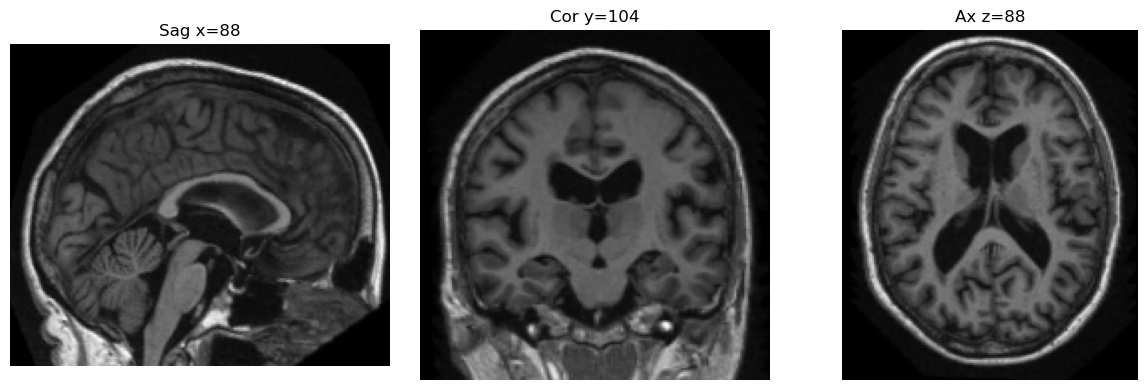

In [6]:
idx = 0
img = nib.load(str(mri_paths[idx]))
img = nib.as_closest_canonical(img)
data = img.get_fdata()
if data.ndim == 4 and data.shape[-1] == 1: data = data[...,0]
cx, cy, cz = data.shape[0]//2, data.shape[1]//2, data.shape[2]//2

fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[0].imshow(np.rot90(data[cx,:,:]), cmap="gray"); axes[0].set_title(f"Sag x={cx}"); axes[0].axis("off")
axes[1].imshow(np.rot90(data[:,cy,:]), cmap="gray"); axes[1].set_title(f"Cor y={cy}"); axes[1].axis("off")
axes[2].imshow(np.rot90(data[:,:,cz]), cmap="gray"); axes[2].set_title(f"Ax z={cz}"); axes[2].axis("off")
plt.tight_layout(); plt.show()


In [7]:
class MRISliceDataset(Dataset):
    def __init__(self, paths, sids, num_slices=20):
        self.paths = list(paths)
        self.sids  = list(sids)
        self.num_slices = int(num_slices)
        self.tf = transforms.Compose([
            transforms.ToTensor(),                    # (H,W) -> (1,H,W)
            transforms.Resize((224,224)),
            transforms.Lambda(lambda x: x.repeat(3,1,1)),  # 1->3 ch
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225]),
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        sid  = self.sids[idx]
        vol = nib.load(str(path)).get_fdata()
        if vol.ndim == 4 and vol.shape[-1] == 1:
            vol = vol[...,0]
        # z-score per volume
        std = float(vol.std())
        if std < 1e-8: std = 1.0
        vol = (vol - float(vol.mean())) / std

        # pick slices spread around center
        z = vol.shape[2]
        z_center = z // 2
        extent   = self.num_slices * 2
        z_start  = max(0, z_center - extent//2)
        z_end    = min(z-1, z_center + extent//2)
        z_idx    = np.linspace(z_start, z_end, num=self.num_slices, dtype=int)

        slices = [self.tf(vol[:,:,int(zi)].astype(np.float32)) for zi in z_idx]  # each (3,224,224)
        batch  = torch.stack(slices, dim=0)  # (S,3,224,224)
        return batch, sid


In [8]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()     # take 512-D features
resnet.eval().to(device)

dataset = MRISliceDataset(mri_paths, subject_ids, num_slices=NUM_SLICES)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


c:\Users\ARASH\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ARASH\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
emb_list, sid_list = [], []

with torch.no_grad():
    for batch, sid in tqdm(loader):
        # batch: (B=1, S, 3, 224,224) -> (S,3,224,224)
        batch = batch.squeeze(0).to(device)
        feats = resnet(batch)                 # (S,512)
        subj_emb = feats.mean(dim=0).cpu().numpy()
        emb_list.append(subj_emb)
        sid_list.append(sid[0])

X = np.vstack(emb_list)           # (N_subjects, 512)
print("Embeddings shape:", X.shape, "| subjects:", len(sid_list))


100%|██████████| 39/39 [00:05<00:00,  7.14it/s]

Embeddings shape: (39, 512) | subjects: 39


In [ ]:
meta = pd.read_excel(META_XLSX)
meta.columns = [c.lower() for c in meta.columns]

# extract OASIS_ID robustly
def extract_oasis_id(row):
    for v in row.astype(str).values:
        m = re.search(r"(OAS1_\d{4})", v)
        if m: return m.group(1)
    return None

meta["oasis_id"] = meta.apply(extract_oasis_id, axis=1)

if "cdr" in meta.columns:
    meta["label"] = (meta["cdr"].astype(float) >= 0.5).astype(int)
elif "group" in meta.columns:
    meta["label"] = meta["group"].astype(str).str.lower().str.contains("dement").astype(int)
else:
    raise ValueError("No CDR or Group for labels.")

# align order with embeddings (sid_list)
meta_used = meta[meta["oasis_id"].isin(sid_list)].dropna(subset=["label"]).copy()
sid_order = meta_used["oasis_id"].tolist()
y = np.array([int(meta_used[meta_used["oasis_id"]==sid]["label"].iloc[0]) for sid in sid_order])

# reorder X to match meta order (sid_order)
sid_to_idx = {sid:i for i, sid in enumerate(sid_list)}
X_ordered = np.vstack([X[sid_to_idx[s]] for s in sid_order])

print("Subjects used:", len(y), "| Label counts:", np.bincount(y))


Subjects used: 39 | Label counts: [27 12]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_ordered, y, test_size=0.25, random_state=SEED, stratify=y
)

In [16]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=SEED)
clf_cv = LogisticRegression(max_iter=1000, class_weight="balanced")

auc_scores = cross_val_score(clf_cv, X_ordered, y, cv=cv, scoring="roc_auc", n_jobs=-1)
acc_scores = cross_val_score(clf_cv, X_ordered, y, cv=cv, scoring="accuracy", n_jobs=-1)

print(f"CV AUC  mean±std: {auc_scores.mean():.3f} ± {auc_scores.std():.3f}")
print(f"CV ACC  mean±std: {acc_scores.mean():.3f} ± {acc_scores.std():.3f}")


CV AUC  mean±std: 0.811 ± 0.152
CV ACC  mean±std: 0.768 ± 0.134


In [ ]:
outdir = Path("results_resnet"); outdir.mkdir(exist_ok=True)

# embeddings
pd.DataFrame(X_ordered, index=sid_order, columns=[f"e{i}" for i in range(X_ordered.shape[1])]) \
  .to_csv(outdir / "resnet_embeddings.csv")

# classifier + metrics
import joblib
joblib.dump(clf, outdir / "resnet_classifier.joblib")

with open(outdir / "metrics.json", "w") as f:
    json.dump({"acc": float(acc), "auc": float(auc), "n": int(len(y))}, f, indent=2)

try:
    with open(outdir / "metrics_cv.json", "w") as f:
        json.dump({
            "cv_auc_mean": float(auc_scores.mean()),
            "cv_auc_std":  float(auc_scores.std()),
            "cv_acc_mean": float(acc_scores.mean()),
            "cv_acc_std":  float(acc_scores.std()),
            "n_subjects":  int(len(y)),
            "cv": "RepeatedStratifiedKFold(5x5, seed=42)"
        }, f, indent=2)
except NameError:
    pass

print("Saved to:", outdir.resolve())


Saved to: F:\university\milan\thesis\trento\code\results_resnet
